# Politician Sentiment Analysis - Classification

Name:       Devin Patel  
Class:      CS 588 - 01  
Term:       FA 22  
Project:    Determining party alignment based on 2016 Election tweets.  
File Purpose: To gauge various classifier accuracies on selected features.
              Confusion matrices, sensitvity, and specificity values are also generated.

## Initialization

In [1]:
# Imports
import numpy as np
import pandas as pd
import scipy.io
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.feature_selection import SelectKBest       # ANOVA
from sklearn.feature_selection import f_regression      # ANOVA

from sklearn.model_selection import train_test_split    # Splits sample set into train/test sets
from sklearn.model_selection import cross_val_score     # Used to evaluate classifier performance
from sklearn.model_selection import StratifiedKFold     # Splits a matrix into K sections

from sklearn.naive_bayes import GaussianNB              # Gaussian Naive Bayes
from sklearn.svm import SVC                             # SVM
from sklearn.neural_network import MLPClassifier        # CNN
from sklearn.pipeline import Pipeline                   # For estimating classifier models
from sklearn.metrics import ConfusionMatrixDisplay      # For gauging classifier model accuracy

import os                                               # For exporting figures


# Paths and Constants
twitter_data_path = r"Data/TweetData.pkl"
RANDOM_STATE = 12
KEPT_FEATURES = 2
NORMALIZE_RANGE = (0, 1)
N_SPLITS = 5


In [2]:
# Exports pyplot figure
import os

def exportFig(fname):
    exportPath = r"Figures/classifiers"

    try:
        if not os.path.exists(exportPath): os.mkdir(exportPath)
    except Exception:
        print("Can't create a directory to store figures, so they will not be saved.")
        return
    
    exportPath = os.path.join(exportPath, fname)
    
    plt.savefig(exportPath)

In [3]:
# Plot function for a classifier
def plot_learning_curve(classifier, X, y, tsizes=np.linspace(0.1, 0.5, 5), label="", color='r', axes=None):
    estimator = Pipeline([("scaler", MinMaxScaler()), ('classifier', classifier)])
    #x_train, x_test, y_train, y_test = train_test_split(iris_x, iris_target, train_size=0.9, random_state=RANDOM_STATE, shuffle=True)
    
    train_scores = []
    test_scores = []
    train_sizes = []
    
    # tsizes are the training sizes [0.1, 0.2, 0.3, 0.4, 0.5]
    for tsize in tsizes:
        tsize_i = tsize*100
        x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=tsize, random_state=RANDOM_STATE, shuffle=True)
        estimator.fit(x_train, y_train)
        train_scores.append(estimator.score(x_train, y_train) * 100)
        test_scores.append(estimator.score(x_test, y_test) * 100)
        train_sizes.append(tsize_i)
    
    if axes is None:
        _, axes = plt.subplot(2)
    
    #axes[0].errorbar(train_sizes, test_scores_mean, yerr=test_scores_std, capsize=5, color=color, label=label)
    axes[0].plot(train_sizes, test_scores, "o-", color=color, label=label)
    axes[1].plot(train_sizes, train_scores, "o-", color=color, label=label)
    
    print(f"Training Accuracy of {label}: {train_scores[-1]}%")
    print(f"Testing Accuracy of {label}: {test_scores[-1]}%")
    print()
    
    return plt

In [4]:
# Loading data from pkl file
X_df = pd.read_pickle(twitter_data_path, compression='infer')

# Separate ground truth from dataframe.
party_gth_df = pd.DataFrame(X_df.pop('Party'))

# Create class labels list for both ground truth dataframes
party_gth_labels = ["R", "D"] # Based on preprocessing: 0 = Republican, 1 = Democrat

# Create feature labels list
feature_labels = X_df.columns.values.tolist()

scaler_model = MinMaxScaler(feature_range=NORMALIZE_RANGE)
scaler_model.fit(X_df)
X = scaler_model.transform(X_df)
X_df = pd.DataFrame(X, columns=feature_labels)

X_subject_df = pd.concat([X_df['Likes'], X_df['Retweets'], X_df['Subjectivity']], axis=1)
X_polar_df = pd.concat([X_df['Likes'], X_df['Retweets'], X_df['Polarity']], axis=1)

X_subject = X_subject_df.to_numpy()
X_polar = X_polar_df.to_numpy()

# Data is ready
print(f"\nShape of main dataframe: {X_df.shape}")



Shape of main dataframe: (65952, 4)


In [5]:
# Initialize feature selection here

# PCA
PCA_KEPT_COMPONENTS = KEPT_FEATURES # Max 4

# Polarity removed
pca = PCA(n_components=PCA_KEPT_COMPONENTS, random_state=RANDOM_STATE)
X_r_subject = pca.fit_transform(X_subject)

# Subjectivity removed
X_r_polar = pca.fit_transform(X_polar)


# LDA
LDA_KEPT_COMPONENTS = 1 # Max 1 because 2 parties
lda = LDA(n_components=LDA_KEPT_COMPONENTS)

X_r2 = lda.fit_transform(X, party_gth_df["Party"])
X_r2_subject = lda.fit_transform(X_subject, party_gth_df['Party'])
X_r2_polar = lda.fit_transform(X_polar, party_gth_df['Party'])


# ANOVA
ANOVA_KEPT_COMPONENTS = KEPT_FEATURES
fs = SelectKBest(score_func=f_regression, k=ANOVA_KEPT_COMPONENTS)

X_r3 = fs.fit_transform(X, party_gth_df['Party'])
X_r3_subject = fs.fit_transform(X_subject, party_gth_df['Party'])
X_r3_polar = fs.fit_transform(X_polar, party_gth_df['Party'])


## Classification Accuracies

In [6]:
# Initialize Classifiers
CNN_LAYERS = (150, 125, 100, 75, 50)
MAX_ITER = 500

# Create a list of classifier models
models = [('NB', GaussianNB()) # Naive Bayes
          ,('SVM (RBF)', SVC(kernel='rbf', gamma='auto', random_state=RANDOM_STATE)) # SVM - RBF
          ,('CNN (MLP)', MLPClassifier(hidden_layer_sizes=CNN_LAYERS, max_iter=MAX_ITER,
                                       activation='relu', solver='adam', random_state=RANDOM_STATE)) # CNN
          ]

MAX_TRAIN_SIZE = 0.5

classifier_labels = {"Gaussian Naive Bayes": (models[0][1], "green")
                    ,"SVM - RBF": (models[1][1], "blue")
                    ,"CNN - MLP": (models[2][1] ,"red")
                    }

### Performance evaluation

In [7]:
# Briefly tests each classifier's accuracy
def classifier_accuracy_comparison(X, y, n_splits=N_SPLITS, title="Default Title", outfile=r"Default.png"):
    # Evaluate each model
    results = []
    names = []
    for name, model in models:
        kfold = StratifiedKFold(n_splits=n_splits, random_state=RANDOM_STATE, shuffle=True)
        cv_results = cross_val_score(model, X, y, cv=kfold, scoring='accuracy')
        results.append(cv_results)
        names.append(name)
        print(f"{name}: {cv_results.mean()*100}% ({cv_results.std()})")

    # Compare Algorithms
    plt.figure()
    plt.boxplot(results, labels=names)
    plt.title(title)

    exportFig(outfile)
    plt.show()

### PCA

NB: 52.60796592709816% (0.0053783729409837555)
SVM (RBF): 53.678432735716086% (5.094248736514064e-05)
CNN (MLP): 53.678432735716086% (1.720379723188609e-05)


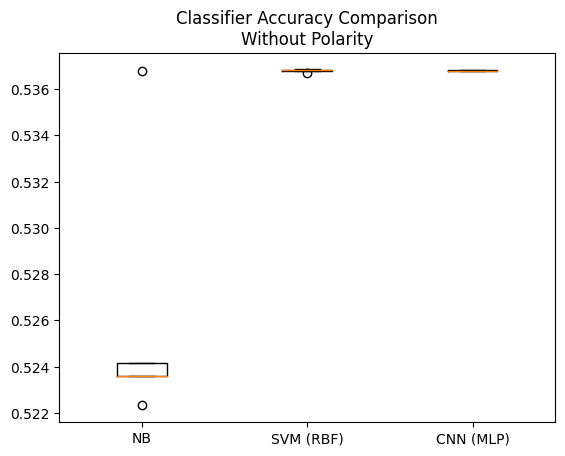

NB: 52.324416979918695% (0.0011200617876395297)
SVM (RBF): 53.678432735716086% (5.094248736514064e-05)
CNN (MLP): 64.8714108782213% (0.005764517309022503)


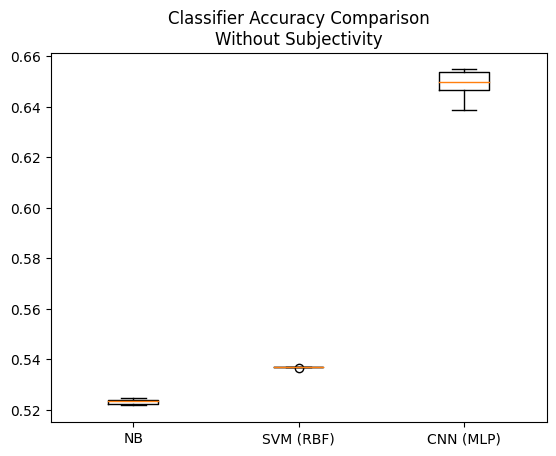

In [8]:
# Tests accuracy of classifiers on PCA
# With subjectivity
classifier_accuracy_comparison(X_r_subject, party_gth_df['Party'], n_splits=N_SPLITS,
                               title='Classifier Accuracy Comparison\nWithout Polarity',
                               outfile=r"Classifier-Comparison-Subject-PCA.png")

# With polarity
classifier_accuracy_comparison(X_r_polar, party_gth_df['Party'], n_splits=N_SPLITS,
                               title='Classifier Accuracy Comparison\nWithout Subjectivity',
                               outfile=r"Classifier-Comparison-Polar-PCA.png")

Training Accuracy of Gaussian Naive Bayes: 52.46542940320232%
Testing Accuracy of Gaussian Naive Bayes: 51.94080543425521%

Training Accuracy of SVM - RBF: 53.787603105288696%
Testing Accuracy of SVM - RBF: 53.5965550703542%

Training Accuracy of CNN - MLP: 64.85625909752547%
Testing Accuracy of CNN - MLP: 64.90781174187288%



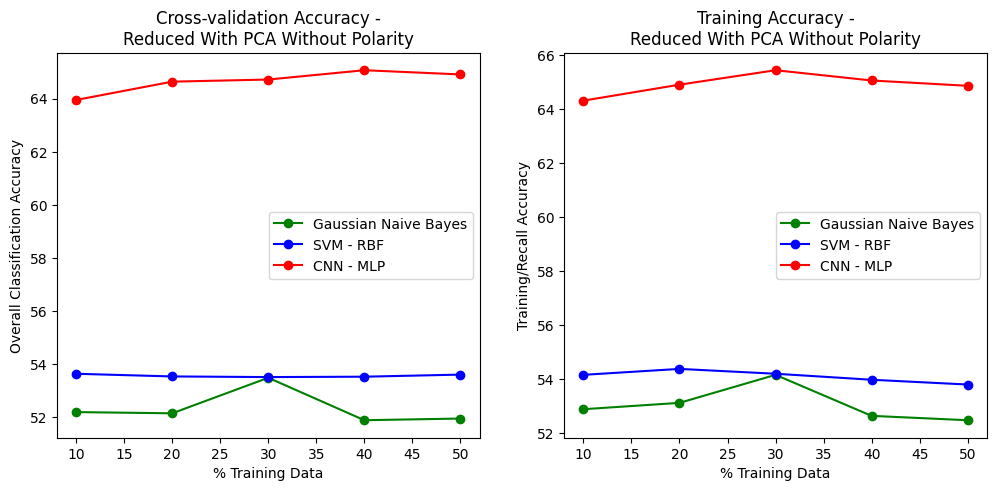

In [9]:
# Creates accuracy plots for subjectivity
_, axes = plt.subplots(1, 2, figsize=(12,5))

for label in classifier_labels:
    classifier = classifier_labels[label][0]
    color = classifier_labels[label][1]
    plot_learning_curve(classifier, X_r_subject, party_gth_df['Party'].astype('int'), tsizes=np.linspace(0.1, MAX_TRAIN_SIZE, int(MAX_TRAIN_SIZE*10)), label=label, color=color, axes=axes)

axes[0].set_xlabel(r"% Training Data")
axes[0].set_ylabel("Overall Classification Accuracy")
axes[0].set_title(f"Cross-validation Accuracy -\nReduced With PCA Without Polarity", fontweight=10)
axes[0].legend()

axes[1].set_xlabel(r"% Training Data")
axes[1].set_ylabel("Training/Recall Accuracy")
axes[1].set_title(f"Training Accuracy -\nReduced With PCA Without Polarity", fontweight=10)
axes[1].legend()

exportFig(r"Classifier-Subject-PCA.png")

plt.show()

Training Accuracy of Gaussian Naive Bayes: 52.91120815138283%
Testing Accuracy of Gaussian Naive Bayes: 52.33503153808831%

Training Accuracy of SVM - RBF: 53.736050460941286%
Testing Accuracy of SVM - RBF: 53.57229500242601%

Training Accuracy of CNN - MLP: 65.01394953905871%
Testing Accuracy of CNN - MLP: 65.2019650655022%



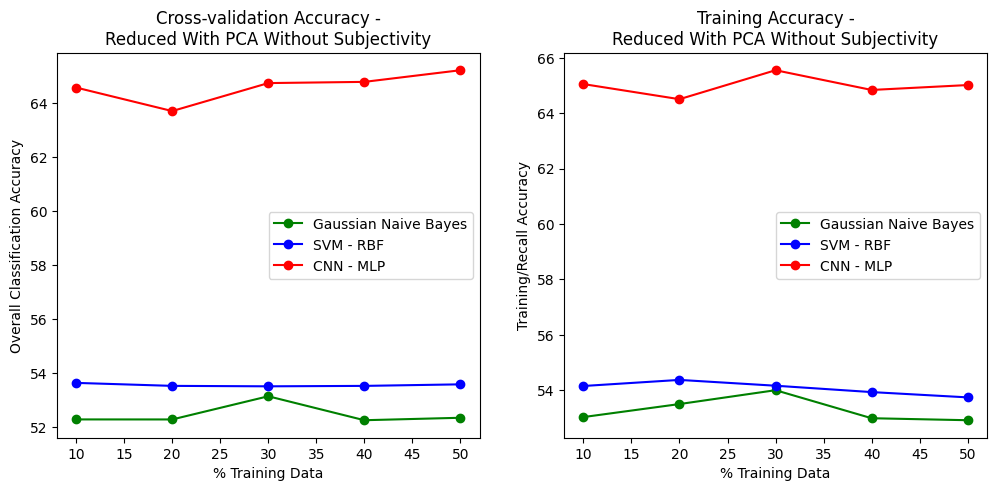

In [10]:
# Creates plots for polarity
_, axes = plt.subplots(1, 2, figsize=(12,5))

for label in classifier_labels:
    classifier = classifier_labels[label][0]
    color = classifier_labels[label][1]
    plot_learning_curve(classifier, X_r_polar, party_gth_df['Party'].astype('int'), tsizes=np.linspace(0.1, MAX_TRAIN_SIZE, int(MAX_TRAIN_SIZE*10)), label=label, color=color, axes=axes)

axes[0].set_xlabel(r"% Training Data")
axes[0].set_ylabel("Overall Classification Accuracy")
axes[0].set_title(f"Cross-validation Accuracy -\nReduced With PCA Without Subjectivity", fontweight=10)
axes[0].legend()

axes[1].set_xlabel(r"% Training Data")
axes[1].set_ylabel("Training/Recall Accuracy")
axes[1].set_title(f"Training Accuracy -\nReduced With PCA Without Subjectivity", fontweight=10)
axes[1].legend()

exportFig(r"Classifier-Polar-PCA.png")

plt.show()

### LDA

NB: 52.15304493742114% (0.020189447188019873)
SVM (RBF): 56.81405286497807% (0.00347019648543301)
CNN (MLP): 61.52506226101618% (0.005795830684408691)


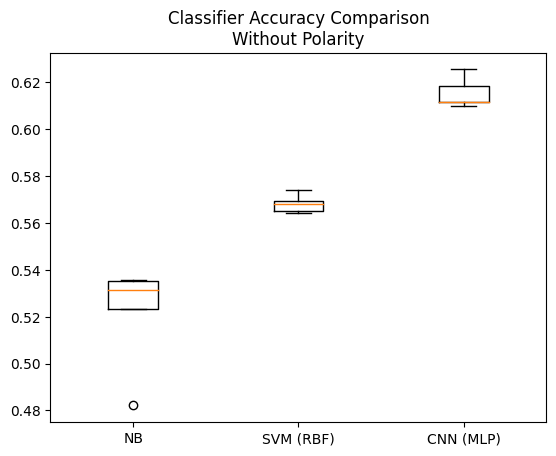

NB: 52.66402673405932% (0.016632149240638862)
SVM (RBF): 54.23641397697525% (0.002230540407841504)
CNN (MLP): 57.83599990551143% (0.0025664740447043184)


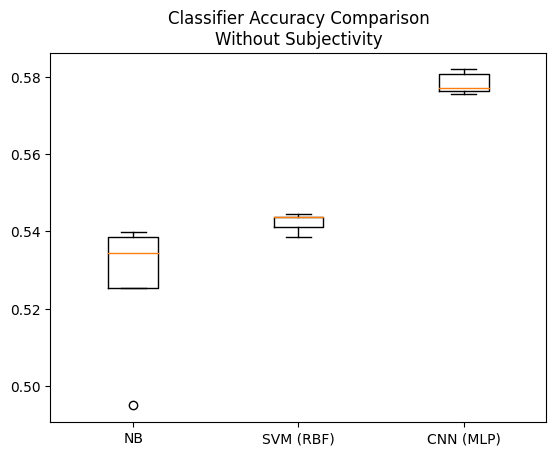

In [11]:
# Tests accuracy of classifiers on LDA
# With subjectivity
classifier_accuracy_comparison(X_r2_subject, party_gth_df['Party'], n_splits=N_SPLITS,
                               title='Classifier Accuracy Comparison\nWithout Polarity',
                               outfile=r"Classifier-Comparison-Subject-LDA.png")

# With polarity
classifier_accuracy_comparison(X_r2_polar, party_gth_df['Party'], n_splits=N_SPLITS,
                               title='Classifier Accuracy Comparison\nWithout Subjectivity',
                               outfile=r"Classifier-Comparison-Polar-LDA.png")

Training Accuracy of Gaussian Naive Bayes: 46.95536147501213%
Testing Accuracy of Gaussian Naive Bayes: 47.686196021348856%

Training Accuracy of SVM - RBF: 53.75424551188743%
Testing Accuracy of SVM - RBF: 53.60262008733624%

Training Accuracy of CNN - MLP: 53.75424551188743%
Testing Accuracy of CNN - MLP: 53.60262008733624%



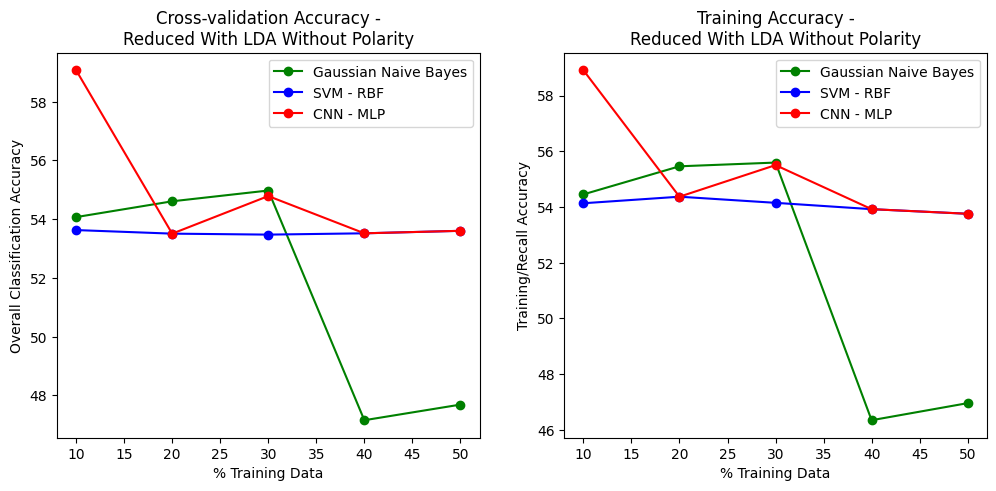

In [12]:
# Creates plots for subjectivity
_, axes = plt.subplots(1, 2, figsize=(12,5))

for label in classifier_labels:
    classifier = classifier_labels[label][0]
    color = classifier_labels[label][1]
    plot_learning_curve(classifier, X_r2_subject, party_gth_df['Party'].astype('int'), tsizes=np.linspace(0.1, MAX_TRAIN_SIZE, int(MAX_TRAIN_SIZE*10)), label=label, color=color, axes=axes)

axes[0].set_xlabel(r"% Training Data")
axes[0].set_ylabel("Overall Classification Accuracy")
axes[0].set_title(f"Cross-validation Accuracy -\nReduced With LDA Without Polarity", fontweight=10)
axes[0].legend()

axes[1].set_xlabel(r"% Training Data")
axes[1].set_ylabel("Training/Recall Accuracy")
axes[1].set_title(f"Training Accuracy -\nReduced With LDA Without Polarity", fontweight=10)
axes[1].legend()

exportFig(r"Classifier-Subject-LDA.png")

plt.show()

Training Accuracy of Gaussian Naive Bayes: 50.215308102862686%
Testing Accuracy of Gaussian Naive Bayes: 51.23423095584667%

Training Accuracy of SVM - RBF: 53.75424551188743%
Testing Accuracy of SVM - RBF: 53.60262008733624%

Training Accuracy of CNN - MLP: 55.43122270742358%
Testing Accuracy of CNN - MLP: 55.203784570596795%



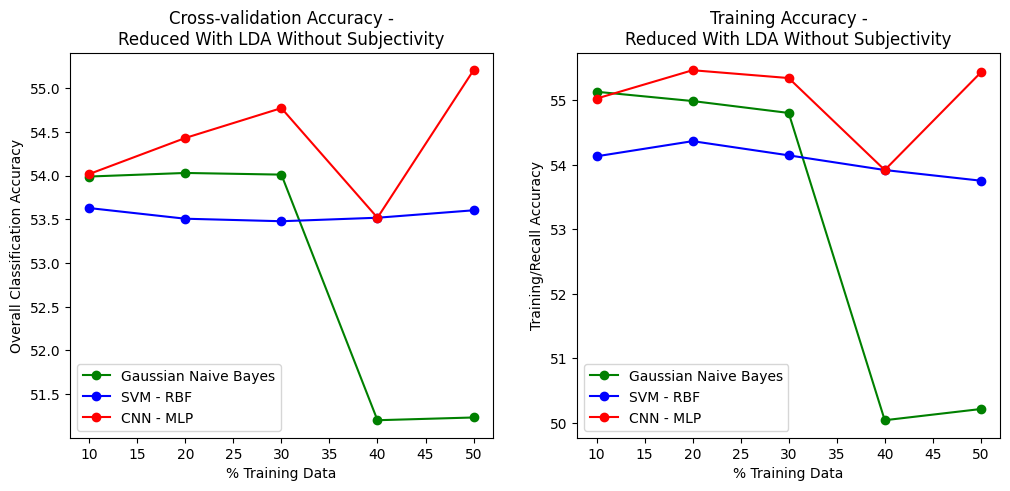

In [13]:
# Creates plots for polarity
_, axes = plt.subplots(1, 2, figsize=(12,5))

for label in classifier_labels:
    classifier = classifier_labels[label][0]
    color = classifier_labels[label][1]
    plot_learning_curve(classifier, X_r2_polar, party_gth_df['Party'].astype('int'), tsizes=np.linspace(0.1, MAX_TRAIN_SIZE, int(MAX_TRAIN_SIZE*10)), label=label, color=color, axes=axes)

axes[0].set_xlabel(r"% Training Data")
axes[0].set_ylabel("Overall Classification Accuracy")
axes[0].set_title(f"Cross-validation Accuracy -\nReduced With LDA Without Subjectivity", fontweight=10)
axes[0].legend()

axes[1].set_xlabel(r"% Training Data")
axes[1].set_ylabel("Training/Recall Accuracy")
axes[1].set_title(f"Training Accuracy -\nReduced With LDA Without Subjectivity", fontweight=10)
axes[1].legend()

exportFig(r"Classifier-Polar-LDA.png")

plt.show()

### ANOVA

NB: 51.33427683968363% (0.018129652569567157)
SVM (RBF): 53.678432735716086% (5.094248736514064e-05)
CNN (MLP): 64.03132296246511% (0.05204027313951947)


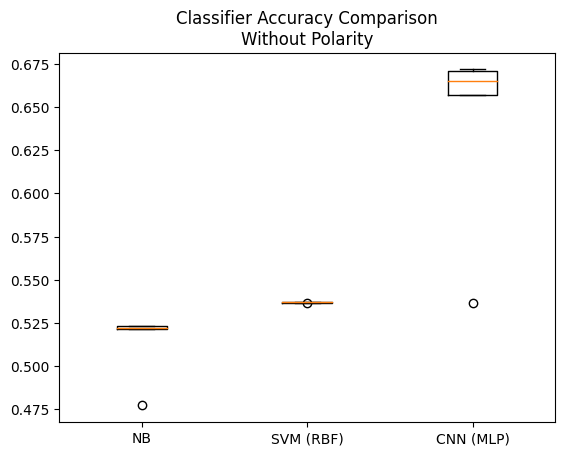

NB: 52.724708400154974% (0.0014185320787950162)
SVM (RBF): 53.67691655043825% (5.362588650796927e-05)
CNN (MLP): 65.21105488734393% (0.0033878441460899536)


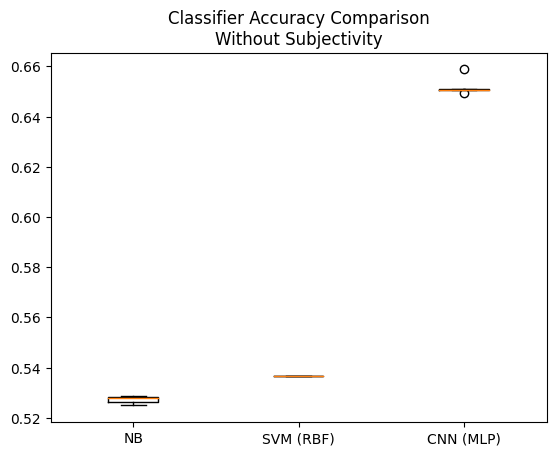

In [14]:
# Tests accuracy of classifiers on ANOVA
# With subjectivity
classifier_accuracy_comparison(X_r3_subject, party_gth_df['Party'], n_splits=N_SPLITS,
                               title='Classifier Accuracy Comparison\nWithout Polarity',
                               outfile=r"Classifier-Comparison-Subject-ANOVA.png")

# With polarity
classifier_accuracy_comparison(X_r3_polar, party_gth_df['Party'], n_splits=N_SPLITS,
                               title='Classifier Accuracy Comparison\nWithout Subjectivity',
                               outfile=r"Classifier-Comparison-Polar-ANOVA.png")

Training Accuracy of Gaussian Naive Bayes: 52.987020863658415%
Testing Accuracy of Gaussian Naive Bayes: 52.410844250363894%

Training Accuracy of SVM - RBF: 53.78457059679768%
Testing Accuracy of SVM - RBF: 53.57532751091703%

Training Accuracy of CNN - MLP: 67.15186802523047%
Testing Accuracy of CNN - MLP: 67.44298884036876%



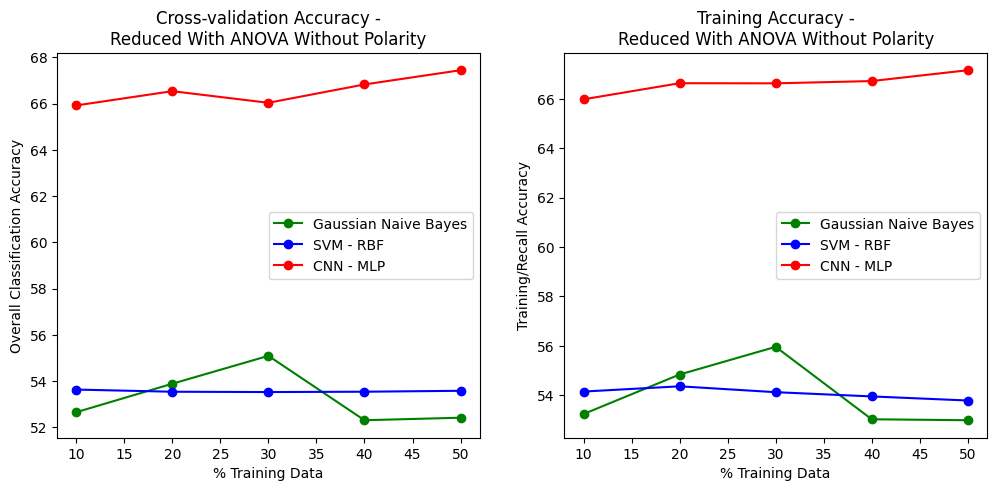

In [15]:
# Creates plots for subjectivity
_, axes = plt.subplots(1, 2, figsize=(12,5))

for label in classifier_labels:
    classifier = classifier_labels[label][0]
    color = classifier_labels[label][1]
    plot_learning_curve(classifier, X_r3_subject, party_gth_df['Party'].astype('int'), tsizes=np.linspace(0.1, MAX_TRAIN_SIZE, int(MAX_TRAIN_SIZE*10)), label=label, color=color, axes=axes)

axes[0].set_xlabel(r"% Training Data")
axes[0].set_ylabel("Overall Classification Accuracy")
axes[0].set_title(f"Cross-validation Accuracy -\nReduced With ANOVA Without Polarity", fontweight=10)
axes[0].legend()

axes[1].set_xlabel(r"% Training Data")
axes[1].set_ylabel("Training/Recall Accuracy")
axes[1].set_title(f"Training Accuracy -\nReduced With ANOVA Without Polarity", fontweight=10)
axes[1].legend()

exportFig(r"Classifier-Subject-ANOVA.png")

plt.show()

Training Accuracy of Gaussian Naive Bayes: 53.3418243571082%
Testing Accuracy of Gaussian Naive Bayes: 52.91727316836487%

Training Accuracy of SVM - RBF: 53.63901018922853%
Testing Accuracy of SVM - RBF: 53.42976710334789%

Training Accuracy of CNN - MLP: 64.97755943716642%
Testing Accuracy of CNN - MLP: 65.15647743813683%



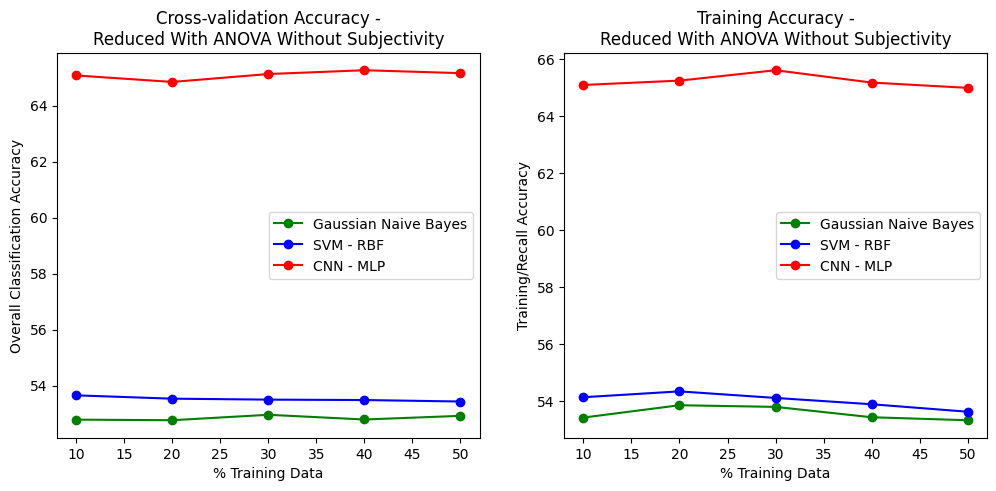

In [16]:
# Creates plots for polarity
_, axes = plt.subplots(1, 2, figsize=(12,5))

for label in classifier_labels:
    classifier = classifier_labels[label][0]
    color = classifier_labels[label][1]
    plot_learning_curve(classifier, X_r3_polar, party_gth_df['Party'].astype('int'), tsizes=np.linspace(0.1, MAX_TRAIN_SIZE, int(MAX_TRAIN_SIZE*10)), label=label, color=color, axes=axes)

axes[0].set_xlabel(r"% Training Data")
axes[0].set_ylabel("Overall Classification Accuracy")
axes[0].set_title(f"Cross-validation Accuracy -\nReduced With ANOVA Without Subjectivity", fontweight=10)
axes[0].legend()

axes[1].set_xlabel(r"% Training Data")
axes[1].set_ylabel("Training/Recall Accuracy")
axes[1].set_title(f"Training Accuracy -\nReduced With ANOVA Without Subjectivity", fontweight=10)
axes[1].legend()

exportFig(r"Classifier-Polar-ANOVA.png")

plt.show()

## Confusion Matrices

In [17]:
# Define classifiers
train_size = 0.3 # Chose 30% based on accuracies plot above
models = [('NB', GaussianNB()) # Naive Bayes
          ,('SVM (RBF)', SVC(kernel='rbf', gamma='auto', random_state=RANDOM_STATE)) # SVM - RBF
          ,('CNN (MLP)', MLPClassifier(hidden_layer_sizes=CNN_LAYERS, max_iter=MAX_ITER,
                                       activation='relu', solver='adam', random_state=RANDOM_STATE)) # CNN
          ]

In [18]:
# Plotting Confusion matrices
def plot_per_class_accuracy(classifier, X1, y1, class_names, class_nums, figsize, tsize, suptitle="", table_loc='top', xticks_rotation='horizontal'):
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=figsize)
    x_train, x_test, y_train, y_test = train_test_split(X1, y1, train_size=tsize, random_state=RANDOM_STATE)
    pipeline = Pipeline([("scaler", MinMaxScaler()), ("classifier", classifier)])
    pipeline.fit(x_train, y_train)
    disp = ConfusionMatrixDisplay.from_estimator(pipeline, x_test, y_test, ax=ax[0], display_labels=class_names, xticks_rotation=xticks_rotation, cmap=plt.cm.Blues)
    
    # Confusion matrix plot
    plt.suptitle(suptitle, fontweight=12)
    
    # Specificity and Sensitivity Table
    table_columns = ['Sensitivity', 'Specificity']
    table_rows = class_names
    table_data = []
    
    
    # Calculate TP, TN, FP, and FN for every class
    confusion_matrix = disp.confusion_matrix
    for class_num in class_nums:
        true_positive = confusion_matrix[class_num][class_num]
        
        false_negative = 0 # Grabs false negative
        for i in range(0, len(confusion_matrix[class_num])):
            if i == class_num: continue
            false_negative += confusion_matrix[class_num][i]
        
        false_positive = 0 # Grabs false positive
        for i in range(0, len(confusion_matrix[class_num])):
            if i == class_num: continue
            false_positive += confusion_matrix[i][class_num]
        
        true_negative = 0 # Grabs true negative
        for i in range(0, len(confusion_matrix)):
            for j in range(0, len(confusion_matrix[class_num])):
                if i == class_num or j == class_num: continue
                true_negative += confusion_matrix[i][j]
        
        # Caculate Sensitivity and Specificity
        sensitivity = true_positive / (true_positive + false_negative)
        specificity = true_negative / (true_negative + false_positive)
        
        # Create a table with specificity and sensitivity values
        table_data.append([sensitivity, specificity])
    
    fig.tight_layout()
    table = ax[1].table(cellText=table_data,
              rowLabels=table_rows,
              colLabels=table_columns,
              loc=table_loc
             )
    ax[1].axis('off')
    
    table.scale(0.65,2)
    table.auto_set_font_size(False)
    table.set_fontsize(8)
    
    fig.subplots_adjust(hspace=1)
    
    return plt

### PCA

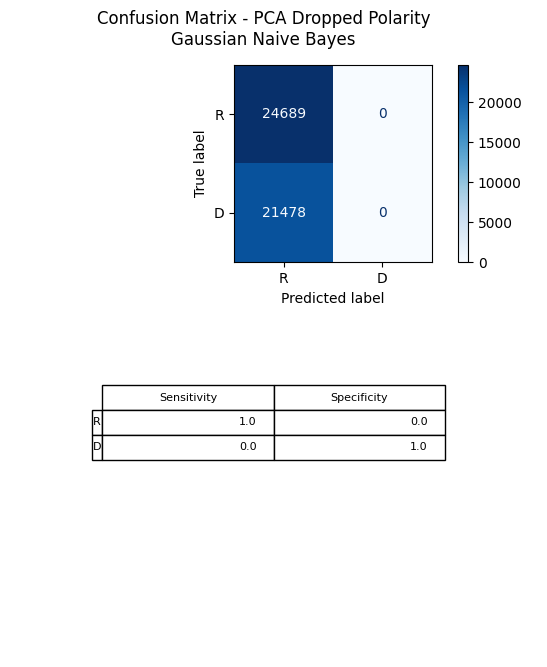

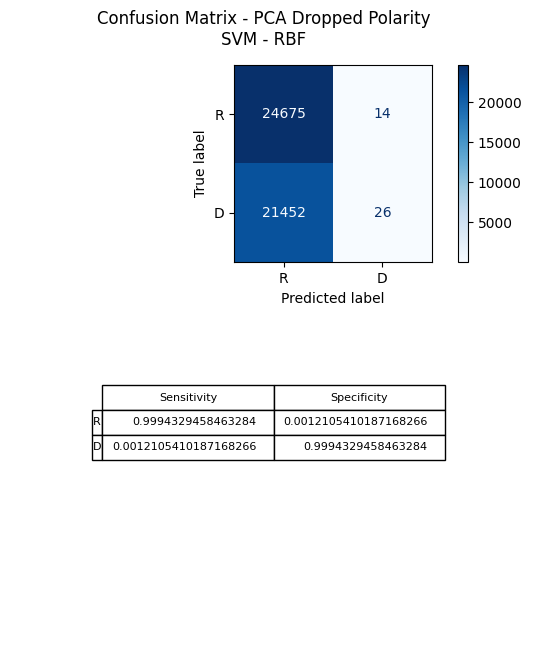

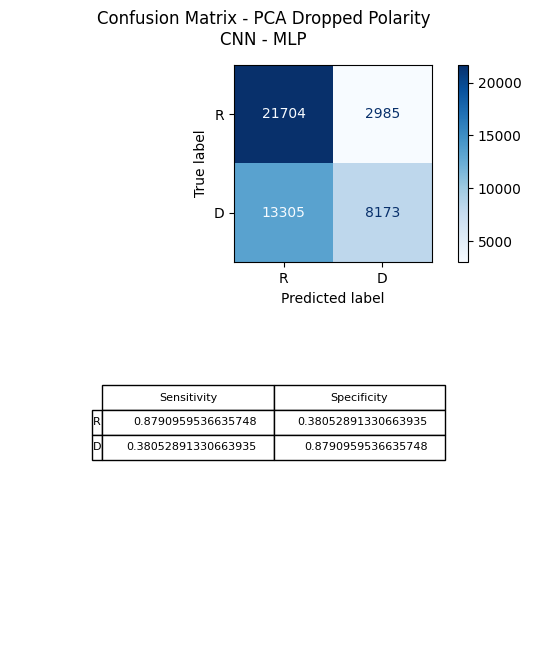

In [20]:
# Party Confusion Matrix for PCA - Subjectivity

for label in classifier_labels:
    classifier = classifier_labels[label][0]
    plot_per_class_accuracy(classifier, X_r_subject, party_gth_df["Party"], tsize=train_size, figsize=(6,7),
                            suptitle=f"Confusion Matrix - PCA Dropped Polarity\n{label}",
                            class_names=party_gth_labels, class_nums=[party_gth_labels.index(i) for i in party_gth_labels])
    exportFig(f"Confusion/PCA/{label}-Matrix-Subject.png")
    plt.show()

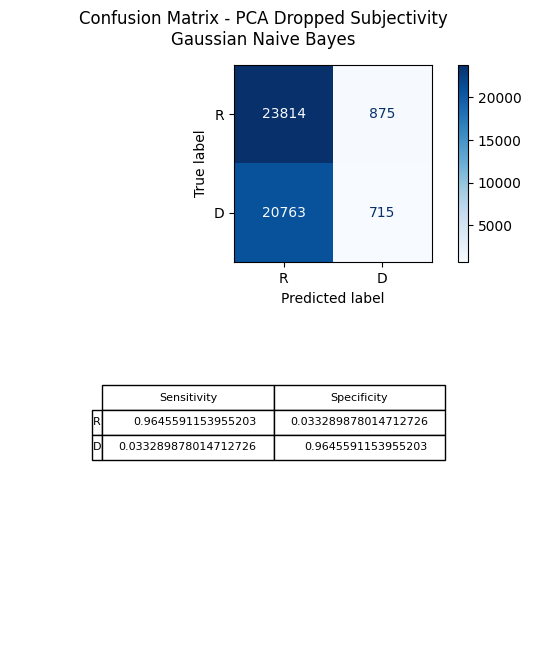

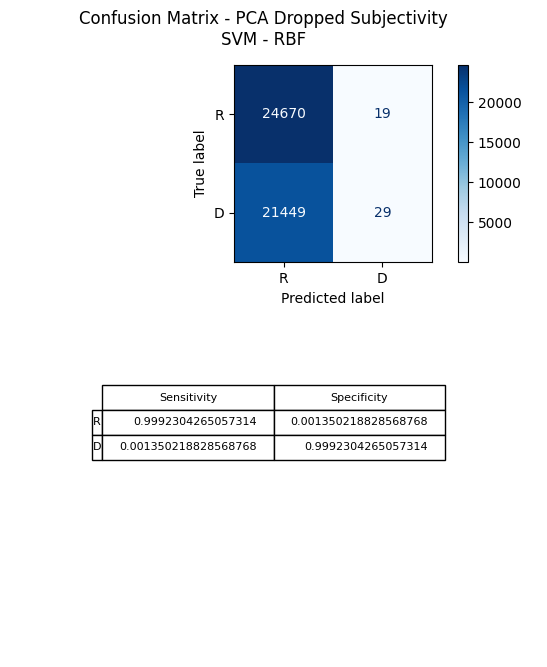

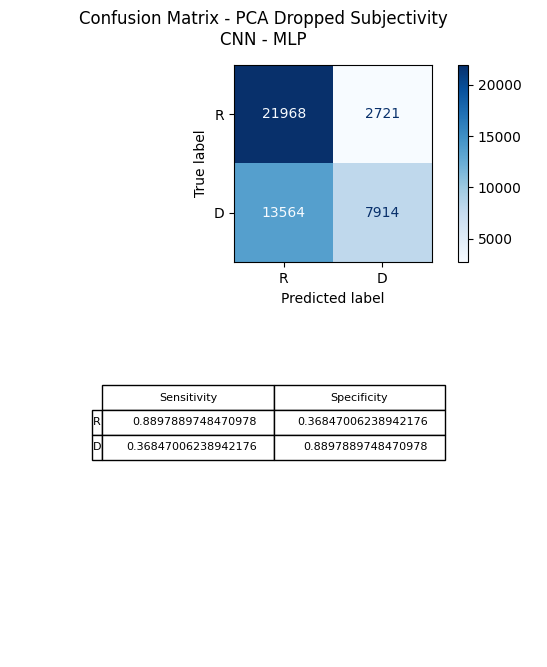

In [21]:
# Party Confusion Matrix for PCA - Polarity

for label in classifier_labels:
    classifier = classifier_labels[label][0]
    plot_per_class_accuracy(classifier, X_r_polar, party_gth_df["Party"], tsize=train_size, figsize=(6,7),
                            suptitle=f"Confusion Matrix - PCA Dropped Subjectivity\n{label}",
                            class_names=party_gth_labels, class_nums=[party_gth_labels.index(i) for i in party_gth_labels])
    exportFig(f"Confusion/PCA/{label}-Matrix-Polar.png")
    plt.show()

### LDA

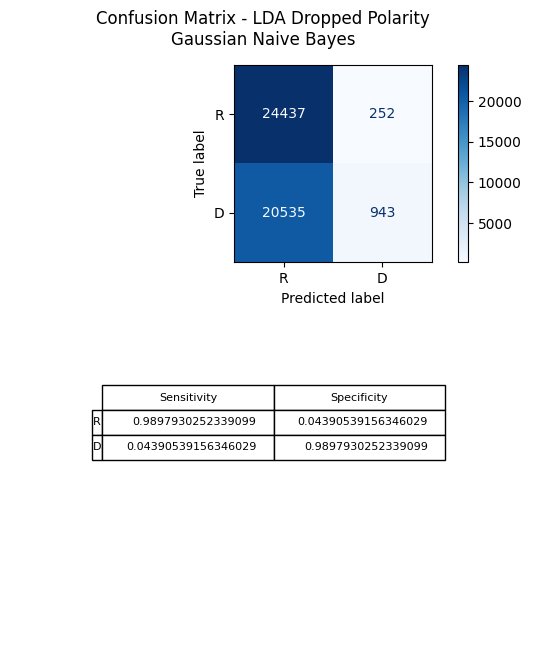

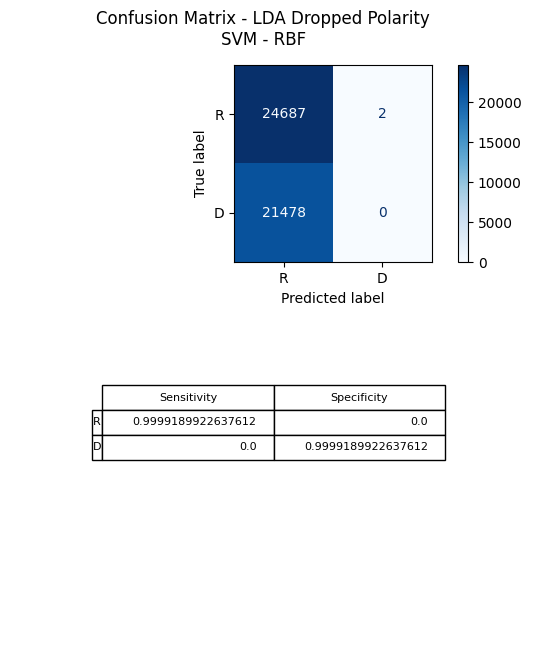

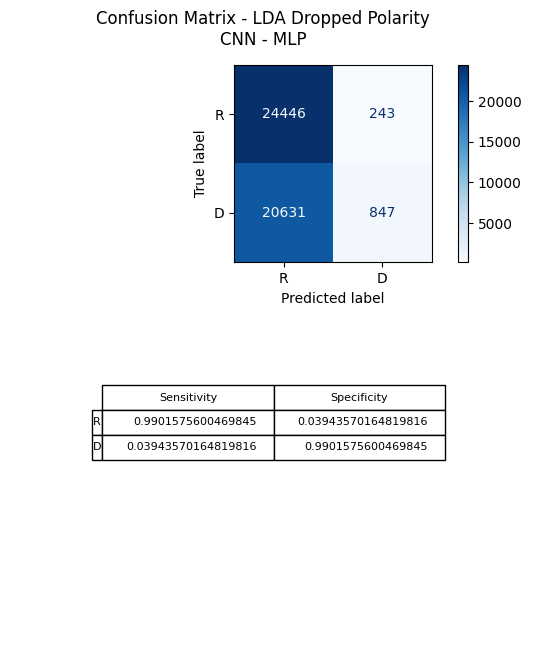

In [22]:
# Party Confusion Matrix for LDA - Subjectivity

for label in classifier_labels:
    classifier = classifier_labels[label][0]
    plot_per_class_accuracy(classifier, X_r2_subject, party_gth_df["Party"], tsize=train_size, figsize=(6,7),
                            suptitle=f"Confusion Matrix - LDA Dropped Polarity\n{label}",
                            class_names=party_gth_labels, class_nums=[party_gth_labels.index(i) for i in party_gth_labels])
    exportFig(f"Confusion/LDA/{label}-Matrix-Subject.png")
    plt.show()

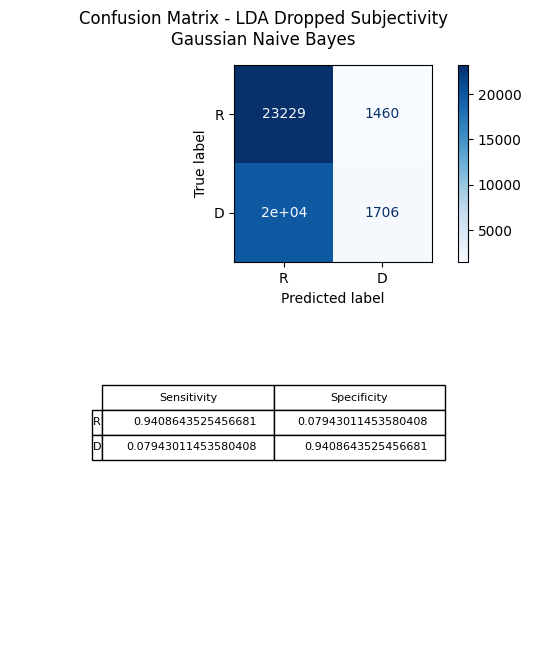

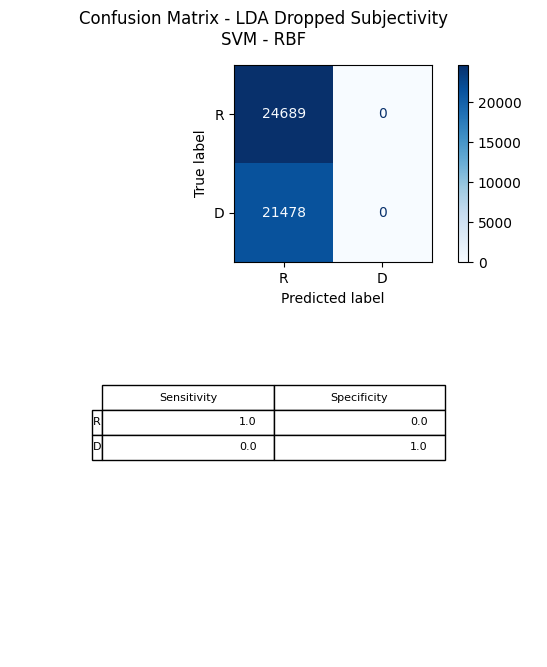

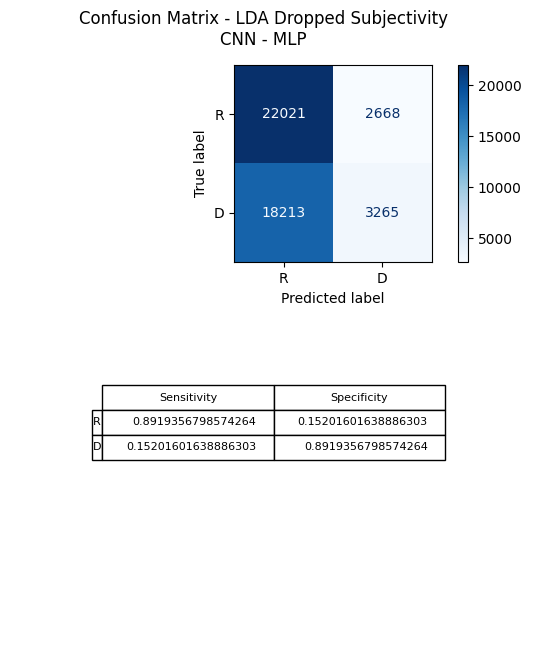

In [23]:
# Party Confusion Matrix for LDA - Polarity

for label in classifier_labels:
    classifier = classifier_labels[label][0]
    plot_per_class_accuracy(classifier, X_r2_polar, party_gth_df["Party"], tsize=train_size, figsize=(6,7),
                            suptitle=f"Confusion Matrix - LDA Dropped Subjectivity\n{label}",
                            class_names=party_gth_labels, class_nums=[party_gth_labels.index(i) for i in party_gth_labels])
    exportFig(f"Confusion/LDA/{label}-Matrix-Polar.png")
    plt.show()

### ANOVA

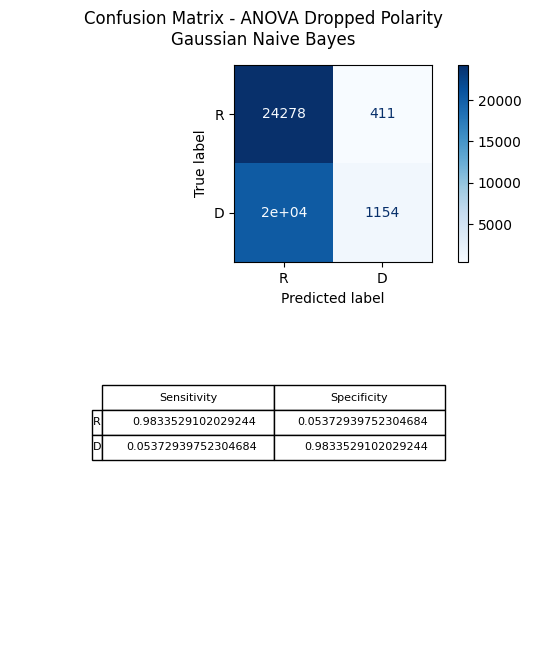

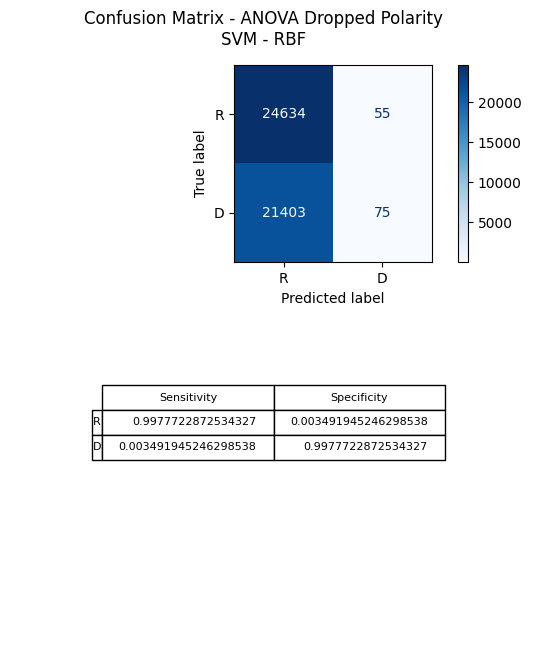

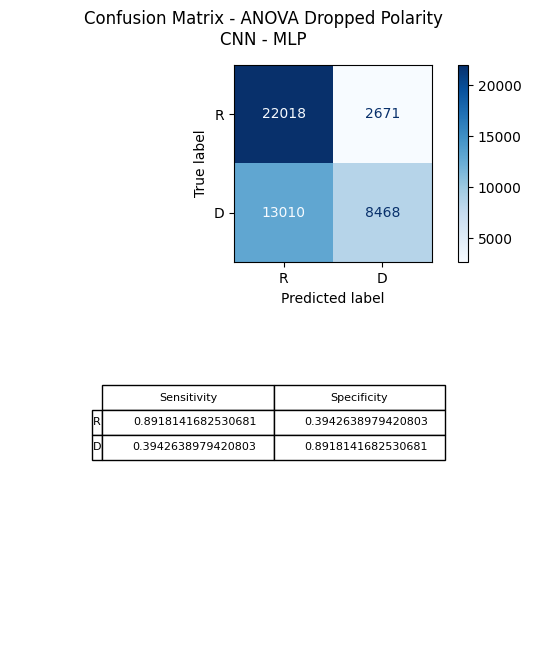

In [24]:
# Party Confusion Matrix for ANOVA - Subjectivity

for label in classifier_labels:
    classifier = classifier_labels[label][0]
    plot_per_class_accuracy(classifier, X_r3_subject, party_gth_df["Party"], tsize=train_size, figsize=(6,7),
                            suptitle=f"Confusion Matrix - ANOVA Dropped Polarity\n{label}",
                            class_names=party_gth_labels, class_nums=[party_gth_labels.index(i) for i in party_gth_labels])
    exportFig(f"Confusion/ANOVA/{label}-Matrix-Subject.png")
    plt.show()

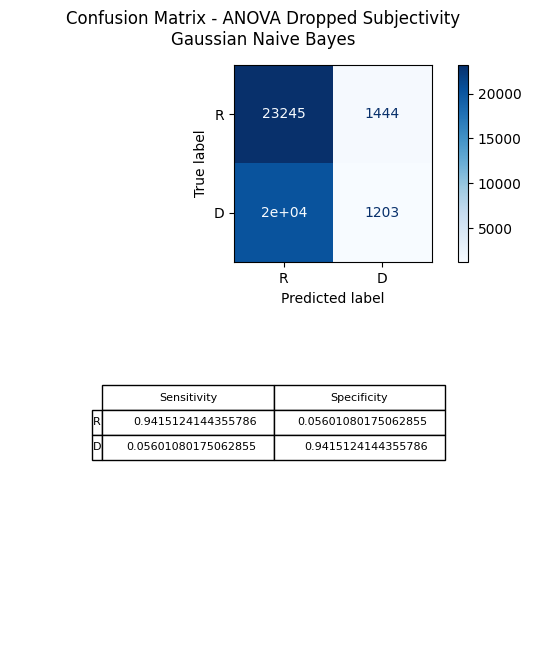

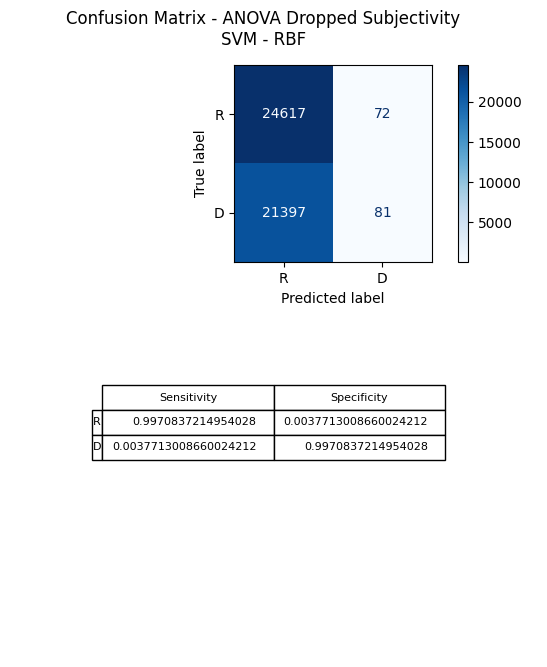

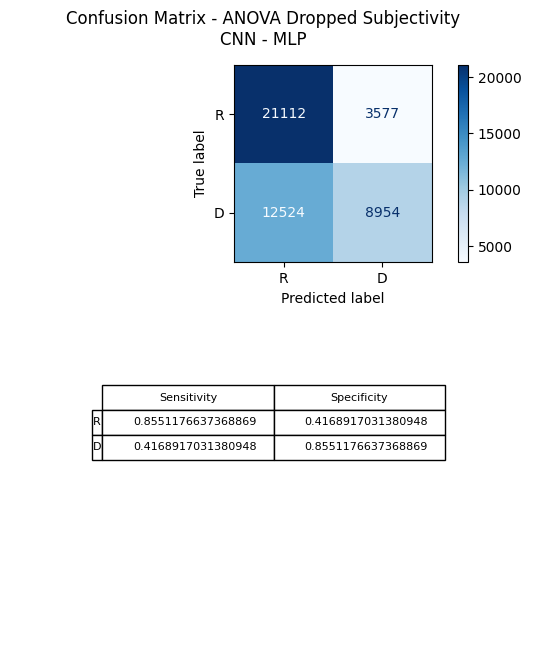

In [25]:
# Party Confusion Matrix for ANOVA - Polarity

for label in classifier_labels:
    classifier = classifier_labels[label][0]
    plot_per_class_accuracy(classifier, X_r3_polar, party_gth_df["Party"], tsize=train_size, figsize=(6,7),
                            suptitle=f"Confusion Matrix - ANOVA Dropped Subjectivity\n{label}",
                            class_names=party_gth_labels, class_nums=[party_gth_labels.index(i) for i in party_gth_labels])
    exportFig(f"Confusion/ANOVA/{label}-Matrix-Polar.png")
    plt.show()